# 1. 导入python库

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping


# 2. 参数设置

In [ ]:
daily_back=20

batch_size=32
epochs=100
patience=10

# LSTM_num=100
# dense_num=20

pop_size = 1
max_iter = 2

mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=2159 #根据查看数据表，得到数值
train_num=1295
test_num=total_day-train_num

# 3. 读取原始数据

In [3]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))


# 4. 标准化

## 4.1 历史数据标准化函数norm

In [4]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [5]:
def split_data(train_num=train_num):
    
    # 先切分
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    
    #再进行归一化
    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)



    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,

            }

## 5.2 进行数据切分

In [6]:
daily_norm_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_norm_train_df.shape)
daily_norm_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_norm_test_df.shape)
fif_norm_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_norm_train_df.shape)
fif_norm_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_norm_test_df.shape)
target_norm_train_df=split_data()['target_train_df']
print('训练目标切分：',target_norm_train_df.shape)
target_norm_test_df=split_data()['target_test_df']
print('测试目标切分：',target_norm_test_df.shape)


日频训练切分： (1295, 8)
日频测试切分： (1012, 8)
十五分钟频训练切分： (20720, 6)
十五分钟频测试切分： (16368, 6)
训练目标切分： (1295, 2)
测试目标切分： (1023, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [7]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
    


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [8]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=daily_back)

# 6.3 调用类中的方法,处理原始数据

In [9]:
DM = origin_data_maker

daily_train_prepared = DM.daily_train_data(daily_norm_train_df)
daily_test_prepared = DM.daily_test_data(daily_norm_test_df)

fif_train_prepared = DM.fif_train_data(fif_norm_train_df)
fif_test_prepared = DM.fif_test_data(fif_norm_test_df)

target_train_prepared = DM.target_train_data(target_norm_train_df)
target_test_prepared = DM.target_test_data(target_norm_test_df)


(1275, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294],
      dtype='int64', length=1295)
日频训练array： (1275, 20, 5)
864 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

# 7. 神经网络模型训练

## 7.1 模型建立 

In [10]:

def my_model(daily_back, LSTM_num, dense_num):
    # 15分钟频输入
    fif_min_input = Input(shape=(16, 5), dtype='float32', name='fif_min_input')
    Conv1D_fif = layers.Conv1D(16, 1, strides=1)(fif_min_input)
    LSTM_fif = layers.LSTM(LSTM_num)(Conv1D_fif)
    
    # 日频输入
    daily_input = Input(shape=(daily_back, 5), dtype='float32', name='daily_input')
    Conv1D_daily = layers.Conv1D(16, 1, strides=1)(daily_input)
    LSTM_daily = layers.LSTM(LSTM_num)(Conv1D_daily)
    
    # 合并与全连接
    concatenated = layers.concatenate([LSTM_fif, LSTM_daily], axis=-1)
    alloy = layers.Dense(dense_num, activation='relu')(concatenated)
    dropout = layers.Dropout(0.2)(alloy)
    output = layers.Dense(1, activation='sigmoid')(dropout)
    
    model = Model([fif_min_input, daily_input], output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['acc'])
    return model

# 创建早停机制

In [11]:
# 创建早停回调
early_stopping = EarlyStopping(
    monitor='val_loss',    # 监控验证集损失
    patience=patience,           # 如果连续10个epoch验证集损失没有改善，则停止训练
    restore_best_weights=True  # 恢复验证集损失最低时的模型权重
)

# 2. 定义适应度函数

In [12]:
import numpy as np

def fitness_function(params):
    LSTM_num = int(params[0])
    dense_num = int(params[1])
    


    
    model = my_model(daily_back=daily_back,  # 替换为实际daily_back值
                     LSTM_num=LSTM_num,
                     dense_num=dense_num,
                     )
    
    history = model.fit(x=[fif_train_prepared,daily_train_prepared],y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])
    return history.history['val_loss'][-1]  # 返回验证损失（越小越好）

# 3. 实现麻雀搜索算法

In [13]:
def sparrow(pop_size, max_iter, dim, lower_bounds, upper_bounds, fitness_func):
    pop = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_sol = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    for t in range(max_iter):
        # 排序
        sorted_idx = np.argsort(fitness)
        pop = pop[sorted_idx]
        fitness = fitness[sorted_idx]

        # 发现者策略
        for i in range(int(pop_size * 0.2)):
            if np.random.rand() < 0.8:
                pop[i] *= np.exp(-i / (np.random.rand() * max_iter))
            else:
                pop[i] += np.random.normal(0, 1)
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 跟随者策略 - 改进矩阵计算
        for i in range(int(pop_size * 0.2), pop_size):
            if i > pop_size / 2:
                pop[i] = np.random.normal(0, 1) * np.exp((pop[-1] - pop[i]) / (i ** 2))
            else:
                # 简化矩阵计算，避免奇异矩阵问题
                A = np.random.choice([-1, 1], size=dim)
                pop[i] = pop[0] + A * (pop[0] - pop[i])
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 警戒者策略
        for i in range(pop_size):
            if fitness[i] > best_fit:
                pop[i] = best_sol + np.random.normal(0, 1)
                # 立即检查边界
                pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 更新最佳解
        fitness = np.array([fitness_func(ind) for ind in pop])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fit:
            best_fit = fitness[current_best_idx]
            best_sol = pop[current_best_idx].copy()

    return best_sol, best_fit

# 4. 运行优化并训练最终模型

In [14]:
# 超参数范围（LSTM_num, dense_num）
lower_bounds = [64, 16]
upper_bounds = [256, 64]
pop_size = pop_size
max_iter = max_iter

best_params, best_fitness =sparrow(pop_size, max_iter, 2, lower_bounds, upper_bounds, fitness_function)

print(f"最佳参数：LSTM_num={int(best_params[0])}, dense_num={int(best_params[1])}")
print(f"最佳验证准确率：{best_fitness}")


# 用最佳参数训练最终模型
final_model = my_model(daily_back=daily_back,  # 替换为实际值
                       LSTM_num=int(best_params[0]),
                       dense_num=int(best_params[1]),
                       )
final_model.fit(x=[fif_train_prepared,daily_train_prepared],y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.5160 - loss: 0.6982 - val_acc: 0.5392 - val_loss: 0.7005
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.5428 - loss: 0.6885 - val_acc: 0.5361 - val_loss: 0.7062
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.5818 - loss: 0.6783 - val_acc: 0.5423 - val_loss: 0.7068
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.5637 - loss: 0.6750 - val_acc: 0.5549 - val_loss: 0.7054
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.5796 - loss: 0.6768 - val_acc: 0.5423 - val_loss: 0.7374
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.5850 - loss: 0.6794 - val_acc: 0.5329 - val_loss: 0.7888
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.5599 - loss: 0.6887 - val_acc: 0.5549 - val_loss: 0.7569
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.5959 - loss: 0.6679 - val_acc: 0.5549 - val_loss: 0.7148
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - ac

## 7.2 模型滞后时长赋值

In [15]:
# model=my_model(daily_back=daily_back)


## 7.3 添加输出模型参数的代码块

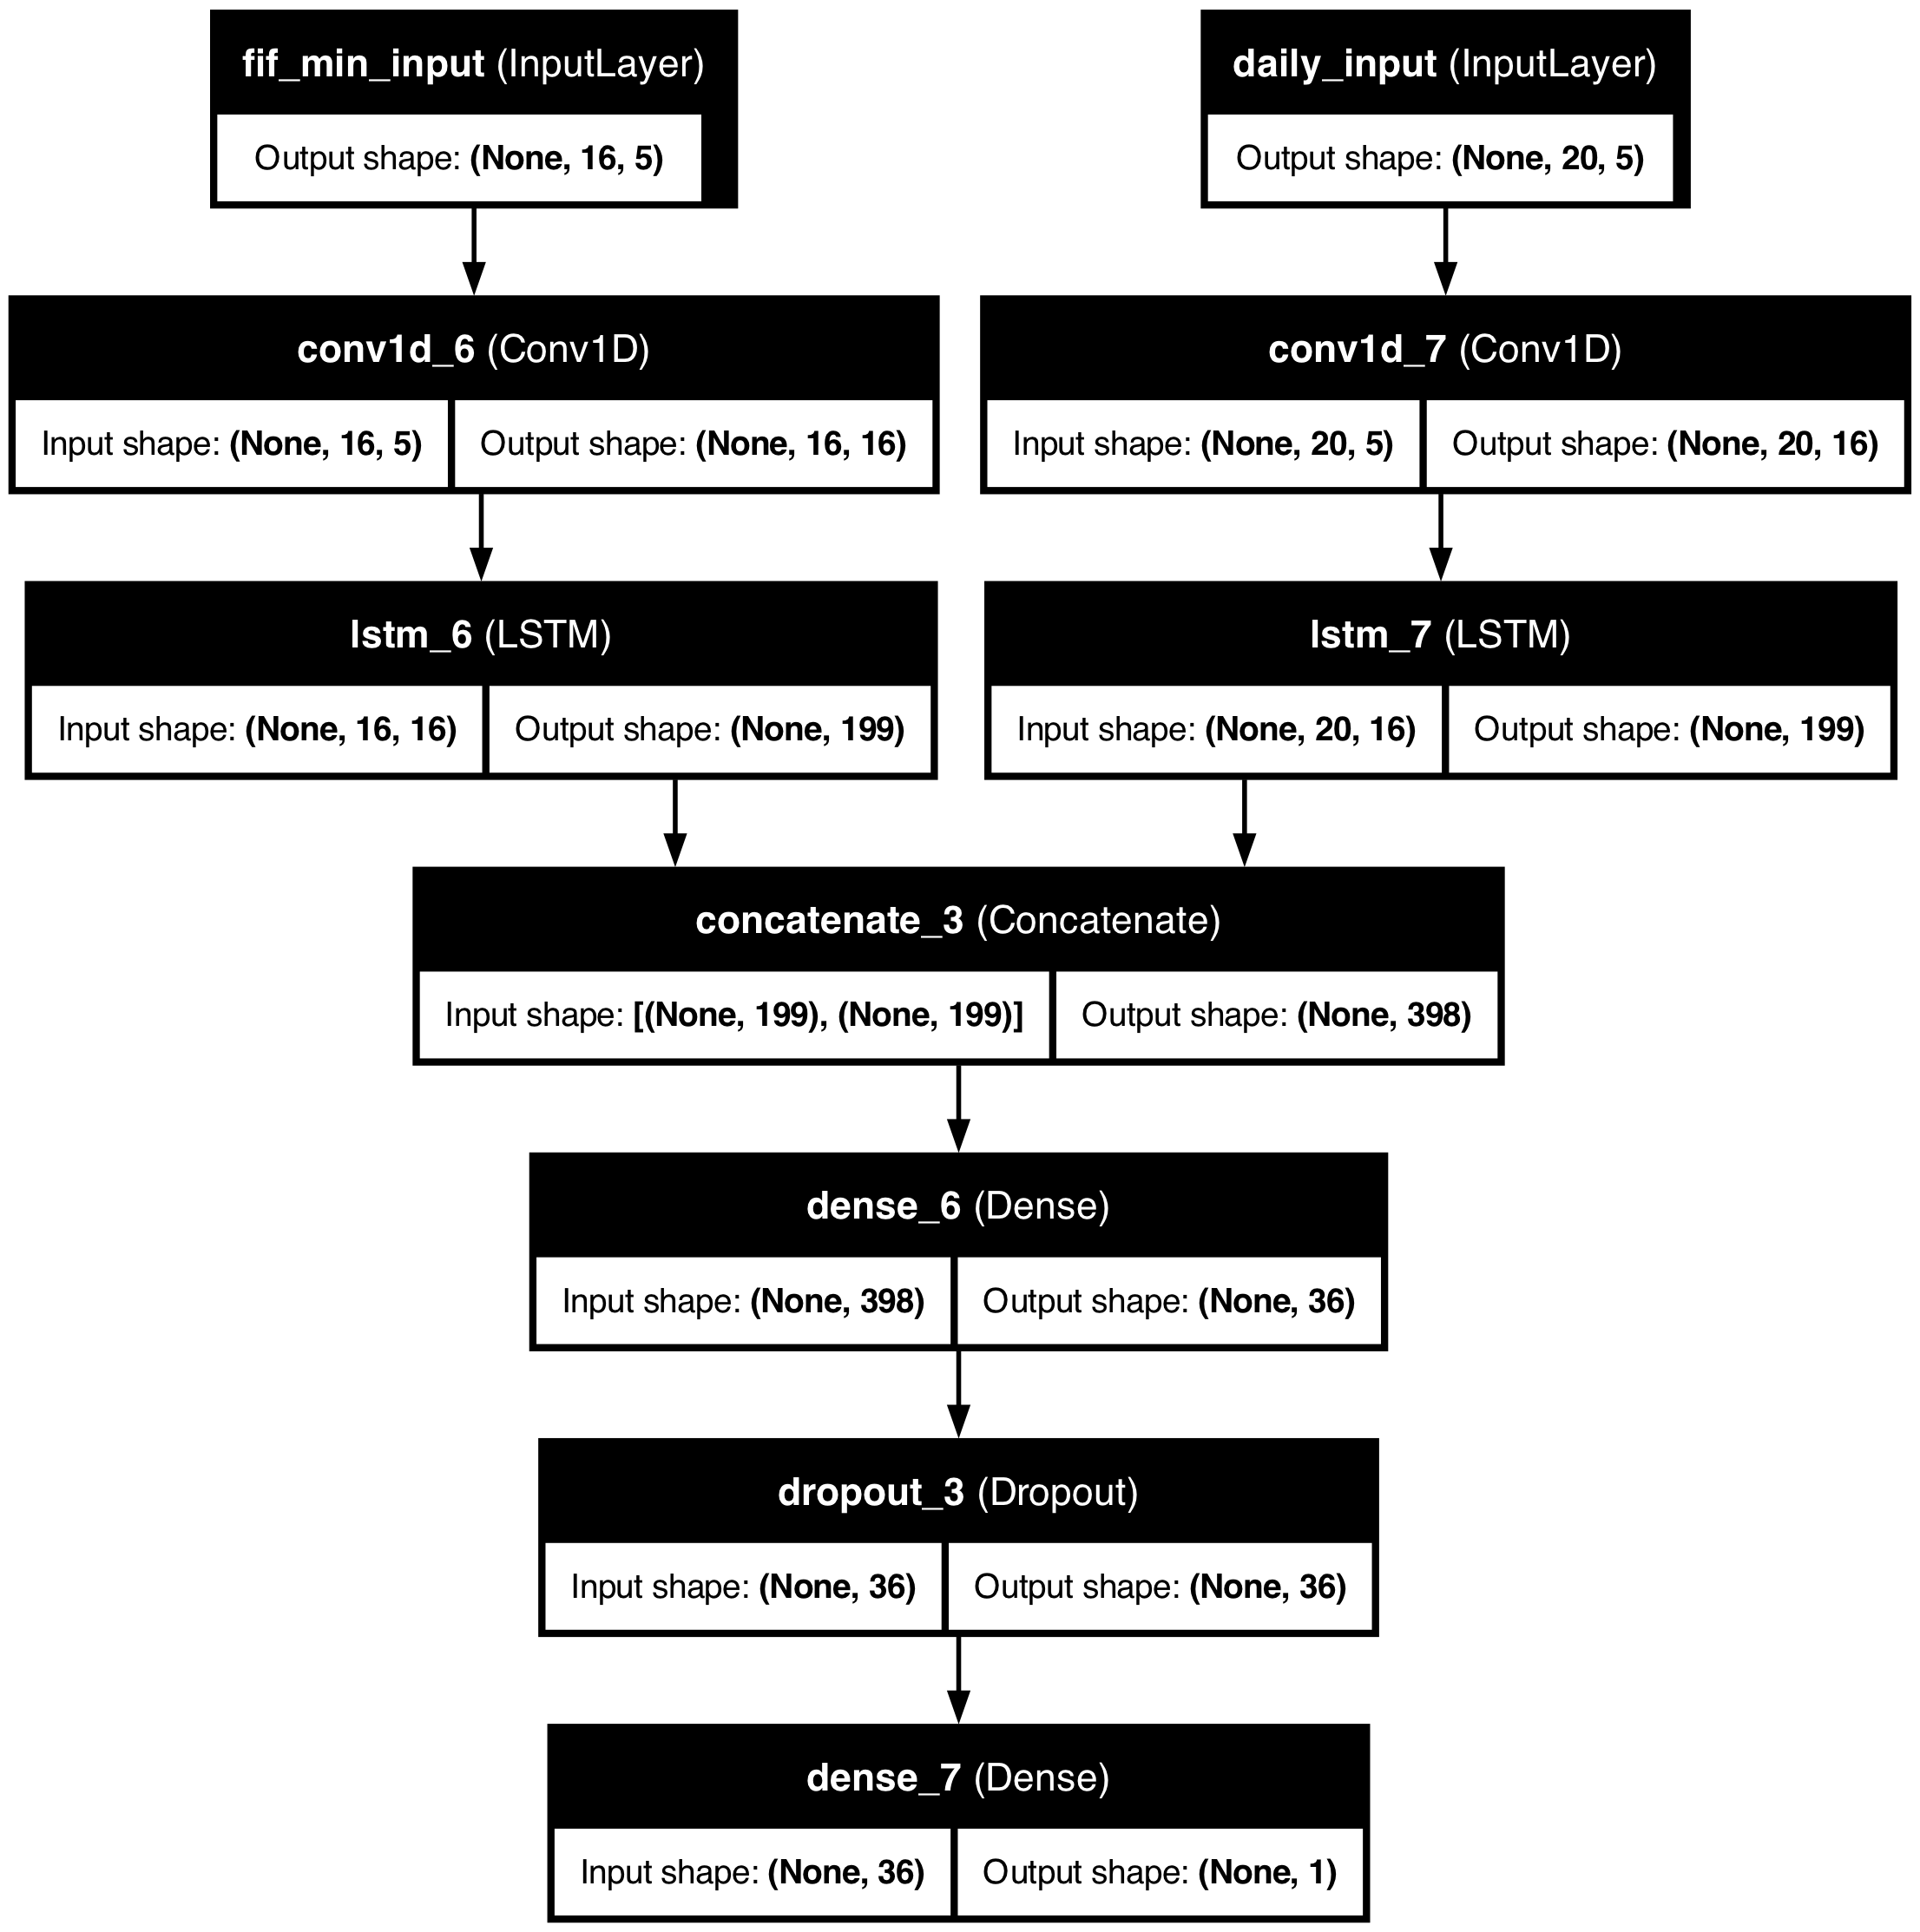

In [16]:
plot_model(final_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 7.4 model.fit(输入训练数据x，标志y)

In [17]:

history = final_model.fit(x=[fif_train_prepared,daily_train_prepared],y=target_train_prepared,
                          batch_size=batch_size,validation_split=0.25,epochs=epochs,callbacks=[early_stopping])


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.6277 - loss: 0.6722 - val_acc: 0.5517 - val_loss: 0.7178
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - acc: 0.6130 - loss: 0.6614 - val_acc: 0.5455 - val_loss: 0.7478
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.5732 - loss: 0.6642 - val_acc: 0.5486 - val_loss: 0.7472
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.5804 - loss: 0.6724 - val_acc: 0.5486 - val_loss: 0.7480
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.5916 - loss: 0.6561 - val_acc: 0.5643 - val_loss: 0.7047
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.6087 - loss: 0.6703 - val_acc: 0.5517 - val_loss: 0.8154
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.6082 - loss: 0.6650 - val_acc: 0.5580 - val_loss: 0.7908
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.6217 - loss: 0.6523 - val_acc: 0.5580 - val_loss: 0.7601
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - ac

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [18]:
loss,accuracy = final_model.evaluate([fif_test_prepared,daily_test_prepared],y=target_test_prepared)
print(loss,accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.5938 - loss: 0.6543
0.6449763774871826 0.6220378875732422


# 8. 回测

# 构建y的函数

In [22]:
# 1. 获取测试集的预测概率（0-1之间）
y_pred_proba = final_model.predict([fif_test_prepared, daily_test_prepared])

# 2. 将概率转换为类别标签（默认以0.5为阈值，可根据需求调整）
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int).flatten().tolist()  # 转换为0/1的一维数组
print("y_pred:", y_pred)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0

#  使用测试集作为回测数据

In [23]:
def get_backtest_data(daily_df, train_num, daily_back):
    """直接获取最终回测数据：索引 >= train_num + daily_back 的开盘价和收盘价"""
    return daily_df.loc[
        daily_df.index >= train_num + daily_back,
        ['open', 'close']
    ]

# 使用示例
backtrader_df = get_backtest_data(daily_df, train_num, daily_back)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [24]:
# 计算收益率
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return'] = backtrader_df['close'] / backtrader_df['open'] - 1

# 将前一天的收盘价作为last_close，这样长度会自动匹配
backtrader_df['last_close'] = backtrader_df['close'].shift(1)

# 只保留需要的部分（根据你的train_num和daily_back条件）
start_idx = train_num + daily_back + 1
backtrader_df.loc[backtrader_df.index < start_idx, 'last_close'] = None

# 计算卖出收益率
backtrader_df['sale_rate_of_return'] = backtrader_df['open'] / backtrader_df['last_close'] - 1

print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list = []
return_multiple_list = []
every_day_return_list = []

         open    close  rate_of_return  day_rate_of_return  last_close  \
1315  3608.60  3624.71             NaN            0.004464         NaN   
1316  3626.33  3597.14       -0.007606           -0.008049     3624.71   
1317  3595.42  3584.21       -0.003595           -0.003118     3597.14   
1318  3565.47  3591.84        0.002129            0.007396     3584.21   
1319  3597.14  3599.54        0.002144            0.000667     3591.84   
...       ...      ...             ...                 ...         ...   
2302  3513.25  3519.65        0.002698            0.001822     3510.18   
2303  3519.81  3505.00       -0.004162           -0.004208     3519.65   
2304  3502.90  3503.78       -0.000348            0.000251     3505.00   
2305  3500.37  3516.83        0.003725            0.004702     3503.78   
2306  3519.48  3534.48        0.005019            0.004262     3516.83   

      sale_rate_of_return  
1315                  NaN  
1316             0.000447  
1317            -0.000478  

# 回测交易逻辑

In [25]:
def backtrader(list, df):
    a = 0  # 持仓状态，0为空仓，1为持仓
    return_multiple = 1  # 累计收益倍数
    trade_day_return_list = []  # 交易日收益列表
    return_multiple_list = []  # 累计收益倍数列表
    every_day_return_list = []  # 每日收益列表
    trade_profits = []  # 新增：记录每笔完整交易的盈亏
    
    current_trade_profit = 1  # 新增：当前交易的收益倍数
    
    for i, v in enumerate(list):
        if (v == 1) & (a == 0):
            # 买入操作
            b = (1 + df.loc[train_num + daily_back + i, 'day_rate_of_return'])
            return_multiple *= b
            a = 1
            current_trade_profit = b  # 开始新交易
            trade_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)

        elif (v == 1) & (a == 1):
            # 持仓中
            b = (1 + df.loc[train_num + daily_back + i, 'rate_of_return'])
            return_multiple *= b
            current_trade_profit *= b  # 累积当前交易收益
            trade_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)
            
        elif (v == 0) & (a == 1):
            # 卖出操作，完成一笔交易
            a = 0
            b = (1 + df.loc[train_num + daily_back + i, 'sale_rate_of_return'])
            return_multiple *= b
            current_trade_profit *= b  # 计算最终交易收益
            trade_profits.append(current_trade_profit - 1)  # 记录这笔交易的盈亏
            current_trade_profit = 1  # 重置当前交易收益
            trade_day_return_list.append(b - 1)
            every_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
            
        elif (v == 0) & (a == 0):
            # 空仓状态
            return_multiple = return_multiple
            every_day_return_list.append(0)
    
    # 返回值中增加每笔交易的盈亏列表
    return a, trade_day_return_list, return_multiple, return_multiple_list, every_day_return_list, trade_profits

In [26]:
# 运行回测
result = backtrader(y_pred, backtrader_df)
a, trade_day_return_list, return_multiple, return_multiple_list, every_day_return_list, trade_profits = result

In [27]:
result=backtrader(y_pred,backtrader_df)

pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)

print('夏普比率：',sharp)
print('收益率：',result[2]-1)


夏普比率： 0.07926905800649457
收益率： 0.00786583916593786


In [28]:
# 计算新增指标：胜率和盈亏比
if trade_profits:  # 确保有交易记录
    # 胜率 = 盈利交易次数 / 总交易次数
    winning_trades = [p for p in trade_profits if p > 0]
    win_rate = len(winning_trades) / len(trade_profits) if trade_profits else 0
    
    # 盈亏比 = 平均盈利 / 平均亏损（取绝对值）
    if winning_trades:
        losing_trades = [p for p in trade_profits if p < 0]
        avg_win = np.mean(winning_trades)
        avg_loss = np.mean(losing_trades) if losing_trades else 0
        
        # 避免除以零错误
        if avg_loss != 0:
            profit_loss_ratio = abs(avg_win / avg_loss)
        else:
            profit_loss_ratio = float('inf')  # 所有交易都盈利
    else:
        profit_loss_ratio = 0  # 没有盈利交易
    
    print("胜率：", win_rate)
    print("盈亏比：", profit_loss_ratio)
else:
    print("没有交易记录，无法计算胜率和盈亏比")

胜率： 0.44545454545454544
盈亏比： 1.2717232165846033


In [29]:
every_day_return_list=result=backtrader(y_pred,backtrader_df)[4]

In [30]:
# 基于完整每日收益计算（推荐）
daily_factors = pd.Series(every_day_return_list) + 1  # 包含空仓日（空仓日为1.0）
cumulative_factors = daily_factors.cumprod()  # 完整累计收益倍数
rolling_max_factors = cumulative_factors.cummax()
drawdown_returns = (cumulative_factors - rolling_max_factors) / rolling_max_factors
max_drawdown = drawdown_returns.min()
print("最大回撤:", max_drawdown)

最大回撤: -0.23870992372600272


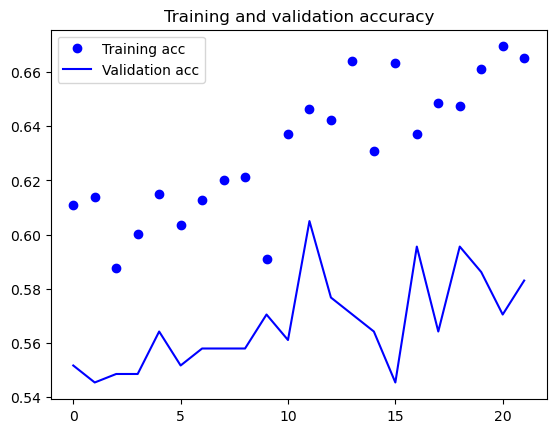

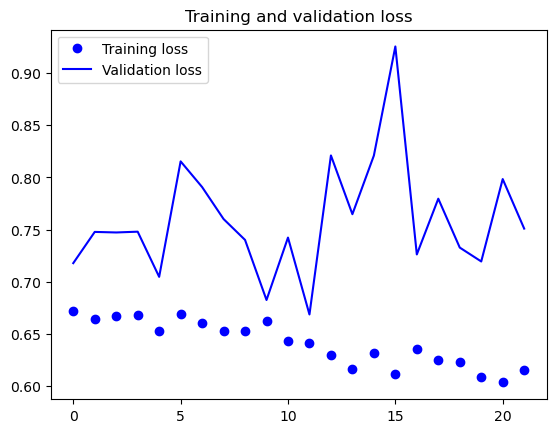

In [31]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [32]:
confusion_matrix = confusion_matrix(target_test_prepared, y_pred,labels=[1,0])
precision_score=precision_score(target_test_prepared, y_pred)
recall_score=recall_score(target_test_prepared, y_pred)
f1_score=f1_score(target_test_prepared, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[249 171]
 [148 276]]
查准率： 0.6272040302267002
查全率： 0.5928571428571429
f1-score: 0.609547123623011


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


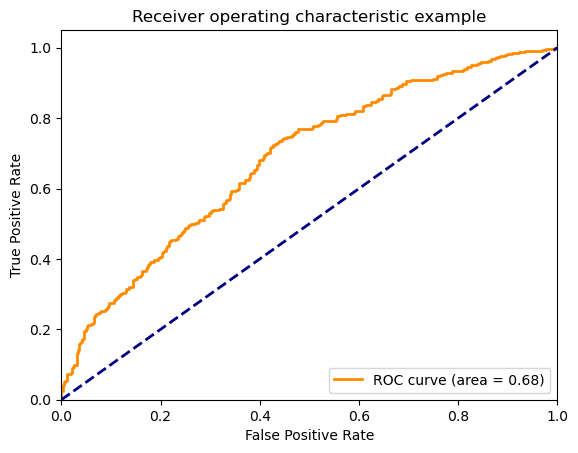

In [33]:
y_predict=final_model.predict([fif_test_prepared,daily_test_prepared]).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test_prepared, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()